For the longest time I have been a reader of Nassim Taleb. Exponential growth, explosive upside, optimisizing for the tails have worked great for me personally. However, I haven't done anything like that with finances. 

From some research, I discovered Mark Spitznagel of Universa, and read his white papers and book: The Dao of Capital. In it, he discussed a naive form of his strategy: 99.5% SPY, 0.5% otm puts with a 2-month expiry, allocated every month. The idea is that if we buy highly out of the money puts, during significant loss periods, our puts will act as explosive insurance. This lets you allocate a significant portion of your wealth to higher-risk investments. 

Let's explore how this would work. 

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
from datetime import datetime

## Data

Erik is an awesome student who reached out to help look into this. He set up three dataframes for us.

### Trading Dates

First, just a list of trading dates to backtest

In [10]:
TRADING_DATES_FILE_PATH = 'trading_dates.csv'
def load_trading_dates(): 
  return pd.to_datetime(
    pd.read_csv(TRADING_DATES_FILE_PATH, header=None)[0],
  )

In [11]:
TRADING_DATES = load_trading_dates()
TRADING_DATES

0     2000-01-21
1     2000-02-18
2     2000-03-17
3     2000-04-20
4     2000-05-19
         ...    
229   2019-02-15
230   2019-03-15
231   2019-04-18
232   2019-05-17
233   2019-06-21
Name: 0, Length: 234, dtype: datetime64[ns]

### Stock Data



In [12]:
SPX_PRICES_FILE_PATH = 'spx_prices.csv'
SPX_PRICES_DATE_COL = 'Date'
SPX_PRICES_OPEN_COL = 'Open'
SPX_PRICES_CLOSE_COL = 'Close'
SPX_PRICES_AVG_COL = 'Avg'
def load_spx_prices():
  spx_prices = pd.read_csv(SPX_PRICES_FILE_PATH)
  spx_prices[SPX_PRICES_DATE_COL] = pd.to_datetime(spx_prices[SPX_PRICES_DATE_COL])
  spx_prices[SPX_PRICES_AVG_COL] = ((spx_prices[SPX_PRICES_OPEN_COL] + spx_prices[SPX_PRICES_CLOSE_COL]) / 2)
  
  return spx_prices

In [13]:
SPX_PRICES = load_spx_prices()
SPX_PRICES

,Date,Open,High,Low,Close,Adj Close,Volume,Avg
0,2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,1462.234985
1,2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1427.320007
2,2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1400.765015
3,2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.779968
4,2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1422.459961
...,...,...,...,...,...,...,...,...
5081,2020-03-16,2508.590088,2562.979980,2380.939941,2386.129883,2386.129883,7781540000,2447.359985
5082,2020-03-17,2425.659912,2553.929932,2367.040039,2529.189941,2529.189941,8358500000,2477.424926
5083,2020-03-18,2436.500000,2453.570068,2280.520020,2398.100098,2398.100098,8755780000,2417.300049
5084,2020-03-19,2393.479980,2466.969971,2319.780029,2409.389893,2409.389893,7946710000,2401.434936


### Options Data

Now, a whole 600MBs of options data

In [14]:
OPTION_PRICES_FILE_PATH = 'option_prices.csv'
OPTION_PRICES_DATE_COL = 'date'
OPTION_PRICES_EXPIRATION_COL = 'exdate'
OPTION_PRICES_MATURITY_COL = 'maturity'
OPTION_PRICES_STRIKE_COL = 'strike_price'
OPTION_PRICES_BID_COL = 'best_bid'
OPTION_PRICES_OFFER_COL = 'best_offer'
OPTION_PRICES_SPREAD_COL = 'spread'
OPTION_PRICES_AVG_COL = 'avg'
OPTION_PRICES_DATE_FMT = '%Y%m%d'

def load_option_prices():
  option_prices = pd.read_csv(OPTION_PRICES_FILE_PATH);
  option_prices[OPTION_PRICES_DATE_COL] = pd.to_datetime(
      option_prices[OPTION_PRICES_DATE_COL],
      format=OPTION_PRICES_DATE_FMT)
  option_prices[OPTION_PRICES_EXPIRATION_COL] = pd.to_datetime(
      option_prices[OPTION_PRICES_EXPIRATION_COL],
      format=OPTION_PRICES_DATE_FMT)
  option_prices[OPTION_PRICES_STRIKE_COL] = option_prices[OPTION_PRICES_STRIKE_COL].div(1000)
  option_prices[OPTION_PRICES_MATURITY_COL] = (
    option_prices[OPTION_PRICES_EXPIRATION_COL] - 
    option_prices[OPTION_PRICES_DATE_COL]
  ).dt.days
  option_prices[OPTION_PRICES_SPREAD_COL] = (
    option_prices[OPTION_PRICES_OFFER_COL] - 
    option_prices[OPTION_PRICES_BID_COL]
  )
  option_prices[OPTION_PRICES_AVG_COL] = (
    (
      option_prices[OPTION_PRICES_OFFER_COL] +
      option_prices[OPTION_PRICES_BID_COL]
    ) / 2
  )

  return option_prices

In [15]:
OPTION_PRICES = load_option_prices()
OPTION_PRICES

,date,exdate,cp_flag,strike_price,best_bid,best_offer,optionid,index_flag,issuer,exercise_style,maturity,spread,avg
0,2000-01-03,2000-03-18,P,1410.0,36.750,38.750,10120210,1,CBOE S&P 500 INDEX,E,75,2.0,37.750
1,2000-01-03,2000-01-22,P,1505.0,55.250,57.250,10000760,1,CBOE S&P 500 INDEX,E,19,2.0,56.250
2,2000-01-03,2000-06-17,P,1350.0,40.750,42.750,10016917,1,CBOE S&P 500 INDEX,E,166,2.0,41.750
3,2000-01-03,2000-01-22,P,1500.0,51.625,53.625,10149633,1,CBOE S&P 500 INDEX,E,19,2.0,52.625
4,2000-01-03,2000-01-22,P,1540.0,84.875,86.875,10056576,1,CBOE S&P 500 INDEX,E,19,2.0,85.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8462523,2019-06-28,2020-06-30,P,3800.0,824.100,848.000,129500433,1,CBOE S&P 500 INDEX,E,368,23.9,836.050
8462524,2019-06-28,2020-06-30,P,3900.0,921.200,945.200,129500434,1,CBOE S&P 500 INDEX,E,368,24.0,933.200
8462525,2019-06-28,2020-06-30,P,4000.0,1018.700,1042.500,129500435,1,CBOE S&P 500 INDEX,E,368,23.8,1030.600
8462526,2019-06-28,2020-06-30,P,4100.0,1116.100,1140.000,129500436,1,CBOE S&P 500 INDEX,E,368,23.9,1128.050


## Data Model

Now that we have some data. Let's create data structures for our trading.

### Portfolio

Let's create a concept of a portfolio. We'll use this data structure to record the state of our assets in a trading day. This can record our SPX quantity, the options we bought, and the cash we have on hand

In [16]:
PORTFOLIO_CASH = 'cash'
PORTFOLIO_SPX_ORDER = 'spx_order'
PORTFOLIO_OPTION_ORDER = 'option_order'
PORTFOLIO_QUANTITY = 'quantity'
PORTFOLIO_STRIKE = 'strike'
PORTFOLIO_EXPIRATION = 'exdate'

def build_portfolio(spx_order, option_order, cash):
  return {
    PORTFOLIO_SPX_ORDER: spx_order, 
    PORTFOLIO_OPTION_ORDER: option_order,
    PORTFOLIO_CASH: cash
  }

def build_spx_order(quantity):
  return {PORTFOLIO_QUANTITY: quantity}

def build_option_order(quantity, strike, expiration_date):
  return {
      PORTFOLIO_QUANTITY: quantity, 
      PORTFOLIO_STRIKE: strike, 
      PORTFOLIO_EXPIRATION: expiration_date
  }

To get a sense of it, here's how it would look if we owned 60 shares of SPX, 

In [17]:
EXAMPLE_PORTFOLIO = build_portfolio(
    spx_order=build_spx_order(quantity=60),
    option_order=build_option_order(
        quantity=100, strike=1400, expiration_date=datetime(2000, 1, 4)
    ),
    cash=100000
)
EXAMPLE_PORTFOLIO

{'spx_order': {'quantity': 60},
 'option_order': {'quantity': 100,
  'strike': 1400,
  'exdate': datetime.datetime(2000, 1, 4, 0, 0)},
 'cash': 100000}

## Trade Book

Next, let's create a dataframe to keep track of our portfolio every trading day. We can use this to measure our performance down the road. 

In [18]:
TRADE_BOOK_DATE = 'date'
TRADE_BOOK_CASH = 'cash'
TRADE_BOOK_SPX_QUANTITY = 'spx_quantity'
TRADE_BOOK_OPTION_QUANTITY = 'option_quantity'
TRADE_BOOK_OPTION_STRIKE = 'option_strike'
TRADE_BOOK_OPTION_EXPIRATION = 'option_expiration_date'

def build_trade_book(): 
  trade_book = pd.DataFrame(
    columns=[
        TRADE_BOOK_DATE,
        TRADE_BOOK_CASH,
        TRADE_BOOK_SPX_QUANTITY,
        TRADE_BOOK_OPTION_QUANTITY,
        TRADE_BOOK_OPTION_STRIKE,
        TRADE_BOOK_OPTION_EXPIRATION
    ]
  )
  trade_book.index = trade_book[TRADE_BOOK_DATE]

  return trade_book


In [19]:
EXAMPLE_TRADE_BOOK = build_trade_book()
EXAMPLE_TRADE_BOOK

,date,cash,spx_quantity,option_quantity,option_strike,option_expiration_date
date,,,,,,


Now, let's create some helper functions. We need some way to record a portfolio into a trade book

In [20]:
def set_portfolio_for_date(trade_book, date, portfolio):
  spx_order = portfolio[PORTFOLIO_SPX_ORDER]
  option_order = portfolio[PORTFOLIO_OPTION_ORDER]
  trade_book.loc[date] = pd.Series({
      TRADE_BOOK_DATE: date,
      TRADE_BOOK_CASH: portfolio[PORTFOLIO_CASH],
      TRADE_BOOK_SPX_QUANTITY: spx_order[PORTFOLIO_QUANTITY],
      TRADE_BOOK_OPTION_QUANTITY: option_order[PORTFOLIO_QUANTITY],
      TRADE_BOOK_OPTION_STRIKE: option_order[PORTFOLIO_STRIKE],
      TRADE_BOOK_OPTION_EXPIRATION: option_order[PORTFOLIO_EXPIRATION]
  })


In [21]:
set_portfolio_for_date(
    trade_book=EXAMPLE_TRADE_BOOK, 
    date=datetime(2000, 1, 3), 
    portfolio=EXAMPLE_PORTFOLIO
)
EXAMPLE_TRADE_BOOK

,date,cash,spx_quantity,option_quantity,option_strike,option_expiration_date
date,,,,,,
2000-01-03,2000-01-03,100000,60,100,1400,2000-01-04


Let's also create a function to convert a trade book row, back into a portfolio

In [22]:
def trade_book_row_to_portfolio(trade_book_row):
  return build_portfolio(
    spx_order=build_spx_order(
        quantity=trade_book_row[TRADE_BOOK_SPX_QUANTITY],
    ),
    option_order=build_option_order(
        quantity=trade_book_row[TRADE_BOOK_OPTION_QUANTITY],
        strike=trade_book_row[TRADE_BOOK_OPTION_STRIKE],
        expiration_date=trade_book_row[TRADE_BOOK_OPTION_EXPIRATION]
    ),
    cash=trade_book_row[TRADE_BOOK_CASH]
  )


In [23]:
trade_book_row_to_portfolio(EXAMPLE_TRADE_BOOK.iloc[0])

{'spx_order': {'quantity': 60},
 'option_order': {'quantity': 100,
  'strike': 1400,
  'exdate': Timestamp('2000-01-04 00:00:00')},
 'cash': 100000}

## Goal

Next, let's create a goal data structure. This can encode our preferences for how we want to allocate SPX, and what kind of options we want to buy: at what otm range and at what expiration.


In [24]:
GOAL_SPX_ALLOC = 'spx_alloc'
GOAL_OTM_RANGE = 'otm_range'
GOAL_MATURITY_RANGE = 'maturity_range'

def build_goal(spx_alloc, otm_range, maturity_range):
  return {
    GOAL_SPX_ALLOC: spx_alloc, 
    GOAL_OTM_RANGE: otm_range, 
    GOAL_MATURITY_RANGE: maturity_range
  }

So if we wanted to allocated 99.5% SPY, and buy options that are within 2-3 month expiration, and 0.3 - 0.5% OTM, we would write

In [25]:
build_goal(spx_alloc=0.995, otm_range=(0.3, 0.5), maturity_range=(60, 90))

{'spx_alloc': 0.995, 'otm_range': (0.3, 0.5), 'maturity_range': (60, 90)}

## Liquidation

In order for us to figure out how much money we have available, let's create some functions to help us liquidate

### SPX

The simplest thing is SPX. given a date and an spx order, let's liquidate our quantity for the average price at that date

In [26]:
def get_spx_value(date, col):
  spx_price_series = SPX_PRICES[SPX_PRICES[SPX_PRICES_DATE_COL] == date]
  if (spx_price_series.shape[0] != 1):
    raise SystemExit("Uh oh, expected to find one spx price")

  return spx_price_series.iloc[0][col]

def liquidate_spx_order(date, spx_order):
  return spx_order[PORTFOLIO_QUANTITY] * get_spx_value(date, SPX_PRICES_AVG_COL)

In [27]:
liquidate_spx_order(datetime(2000, 1, 3), build_spx_order(quantity=60))

87734.09913

### Option

For an option order, we search through the database, to find the option that has the same date, expiration, and strike price

In [28]:
def liquidate_option_order(date, option_order):
  options_for_this_date = OPTION_PRICES[
      OPTION_PRICES[OPTION_PRICES_DATE_COL] == date
  ]
  options_with_expiration = options_for_this_date[
    OPTION_PRICES[OPTION_PRICES_EXPIRATION_COL] == 
    option_order[PORTFOLIO_EXPIRATION]
  ]
  options_with_strike = options_with_expiration[
    OPTION_PRICES[OPTION_PRICES_STRIKE_COL] == 
    option_order[PORTFOLIO_STRIKE]
  ]
  found_series = options_with_strike.iloc[0]
  if found_series.empty:
    raise SystemExit("Uh oh. I need to be able to find the option to sell it")
  
  price = found_series[OPTION_PRICES_OFFER_COL]
  
  return option_order[PORTFOLIO_QUANTITY] * price

In [29]:
liquidate_option_order(
    datetime(2000, 1, 3), 
    build_option_order(
        quantity=100, 
        strike=1410, 
        expiration_date=datetime(2000, 3, 18)
     )
)

3875.0

### Putting it together

Now that we have our functions for SPX and options, let's liquidate the portfolio

In [45]:
def liquidate(date, portfolio):
  cash = portfolio[PORTFOLIO_CASH]
  spx_order = portfolio[PORTFOLIO_SPX_ORDER]
  option_order = portfolio[PORTFOLIO_OPTION_ORDER]
  
  return (
    (cash or 0) + 
    (liquidate_spx_order(date, spx_order) if spx_order else 0) + 
    (liquidate_option_order(date, option_order) if option_order else 0)
  )

In [32]:
liquidate(datetime(2000, 1, 3), build_portfolio(spx_order=None, option_order=None, cash=1000))

1000

## Buying an order

Now let's create the logic that will help us buy our SPX and option orders.

### SPX

We want to buy a certain allocation of SPX, and return the cash that's left over

In [33]:
def buy_spx_order(date, cash_available, alloc):
  price_of_spx = get_spx_value(date, SPX_PRICES_AVG_COL)
  quantity = (cash_available * alloc) // price_of_spx
  cash_remaining = cash_available - (price_of_spx * quantity)
  
  return (build_spx_order(quantity), cash_remaining)

In [34]:
buy_spx_order(datetime(2000, 1, 3), 100000, 1)

({'quantity': 68.0}, 568.0209860000032)

### Option

Okay, now let's create a function to buy an option. We want this option to be within our "out of the money range", and within our "expiration range". If it's in that range, let's get the cheapest one

First, let's create a helper method to buy an option within the "out of the money range":

In [35]:
def options_for_otm_range(date, options, otm_range):
  current_spx_price = get_spx_value(date, SPX_PRICES_AVG_COL)
  min_strike = (1 - otm_range[1]) * current_spx_price
  max_strike = (1 - otm_range[0]) * current_spx_price
  
  return options[
    options[OPTION_PRICES_STRIKE_COL].between(min_strike, max_strike)
  ]

Next, let's put the code together to find the best option orders:

In [36]:
def find_best_option_rows(
  date, 
  otm_range, 
  maturity_range):
  options_on_this_date = OPTION_PRICES[OPTION_PRICES[OPTION_PRICES_DATE_COL] == date]
  options_within_expiration_range = options_on_this_date[
    options_on_this_date[OPTION_PRICES_MATURITY_COL]
      .between(maturity_range[0], maturity_range[1])
  ]
  options_within_otm_range = options_for_otm_range(
    date,
    options_within_expiration_range,
    otm_range
  )
  options_sorted_by_lowest_price_at_highest_strike = options_within_otm_range.sort_values(
    by=[OPTION_PRICES_OFFER_COL, OPTION_PRICES_STRIKE_COL], 
    ascending=[True, False]
  )
  
  return options_sorted_by_lowest_price_at_highest_strike

Let's see how that looks

In [37]:
date = datetime(2000, 1, 3)
spx_price = get_spx_value(date, SPX_PRICES_AVG_COL)
print('date:', date, 'spx price:', spx_price, '30% otm:', spx_price * 0.7, '20% otm:', spx_price * 0.8)
find_best_option_rows(
    date,
    (0.2, 0.3),
    (60, 100)
).sort_values(by=[OPTION_PRICES_EXPIRATION_COL])

date: 2000-01-03 00:00:00 spx price: 1462.2349855 30% otm: 1023.56448985 20% otm: 1169.7879884000001


,date,exdate,cp_flag,strike_price,best_bid,best_offer,optionid,index_flag,issuer,exercise_style,maturity,spread,avg
68,2000-01-03,2000-03-18,P,1025.0,1.625,2.125,10697611,1,CBOE S&P 500 INDEX,E,75,0.50,1.875
93,2000-01-03,2000-03-18,P,1050.0,2.250,2.500,10816465,1,CBOE S&P 500 INDEX,E,75,0.25,2.375
64,2000-01-03,2000-03-18,P,1075.0,2.500,3.250,10805755,1,CBOE S&P 500 INDEX,E,75,0.75,2.875
9,2000-01-03,2000-03-18,P,1100.0,3.125,3.875,10038124,1,CBOE S&P 500 INDEX,E,75,0.75,3.500
182,2000-01-03,2000-03-18,P,1125.0,3.875,4.625,11709606,1,CBOE S&P 500 INDEX,E,75,0.75,4.250
132,2000-01-03,2000-03-18,P,1150.0,4.750,5.500,11347246,1,CBOE S&P 500 INDEX,E,75,0.75,5.125


Now, let's put it together and buy the option:

In [38]:
def buy_option_order(
  date, 
  cash_available, 
  otm_range, 
  maturity_range):
  best_option_rows = find_best_option_rows(
    date, otm_range, maturity_range
  )
  if best_option_rows.empty:
    raise SystemExit("wasn't able to find an option for {}".format(date))
  best_option_row = best_option_rows.iloc[0]
  strike = best_option_row[OPTION_PRICES_STRIKE_COL]
  expiration = best_option_row[OPTION_PRICES_EXPIRATION_COL]
  price = best_option_row[OPTION_PRICES_OFFER_COL]
  quantity = cash_available // price
  
  option_order = build_option_order(quantity=quantity, strike=strike, expiration_date=expiration)
  cash_remaining = cash_available - (quantity * price)
  
  return (option_order, cash_remaining)

In [39]:
date = datetime(2000, 1, 3)
buy_option_order(
    date,
    1000,
    (0.2, 0.3),
    (60, 100)
)

({'quantity': 470.0,
  'strike': 1025.0,
  'exdate': Timestamp('2000-03-18 00:00:00')},
 1.25)

## Trading

To put it all together, let's write out trading algorithm. Effectively: 

Every trading day, 
1. We'll liquidate
2. Then we'll buy according to our goal: allocation, otm range, expiration range, etc

In [40]:
def trade_for_date(date, goal, portfolio):
  cash_available = liquidate(date, portfolio)
  spx_order, cash_remaining_after_spx = buy_spx_order(date, cash_available, goal[GOAL_SPX_ALLOC])
  option_order, cash_remaining_after_option = buy_option_order(
    date, 
    cash_remaining_after_spx,
    goal[GOAL_OTM_RANGE],
    goal[GOAL_MATURITY_RANGE],
  )
  return build_portfolio(
    spx_order=spx_order, option_order=option_order, cash=cash_remaining_after_option
  )

In [41]:
trade_for_date(
    datetime(2000,1, 3),
    build_goal(spx_alloc=0.9, otm_range=(0.2, 0.3), maturity_range=(60, 100)),
    build_portfolio(spx_order=None, option_order=None, cash=100000)
)

{'spx_order': {'quantity': 61.0},
 'option_order': {'quantity': 5084.0,
  'strike': 1025.0,
  'exdate': Timestamp('2000-03-18 00:00:00')},
 'cash': 0.1658845000056317}

## Simulation

Now, let's write code to run the strategy

In [42]:
def simulate(goal, cash):
  trade_book = build_trade_book()
  portfolio = build_portfolio(spx_order=None, option_order=None, cash=cash)
  for date in TRADING_DATES:
    portfolio = trade_for_date(
      date,
      goal,
      portfolio
    )
    set_portfolio_for_date(trade_book, date, portfolio)
  
  return trade_book

 And let's write some code to plot how we do.

In [43]:
def simulate_and_compare(goal, cash):
  trade_book = simulate(goal, cash)
  (just_spx_order, just_spx_order_cash_remaining) = buy_spx_order(
      TRADING_DATES.iloc[0],
      cash,
      1
  )
  def format_for_plot(row):
      date = row[TRADE_BOOK_DATE]
      return pd.Series({
          'spy': liquidate_spx_order(date, just_spx_order) + just_spx_order_cash_remaining,
          'put': liquidate(date, trade_book_row_to_portfolio(row))
      })
  
  plot_df = trade_book.apply(format_for_plot, axis=1)
  plot_df.plot()
  plt.show()

## Exploration

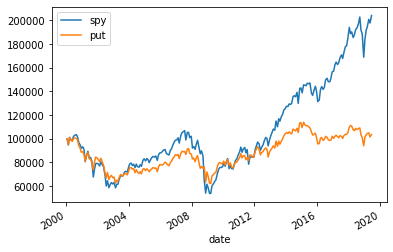

In [44]:
simulate_and_compare(
    build_goal(spx_alloc=0.995, otm_range=(0.2, 0.3), maturity_range=(60, 220)),
    100000
)

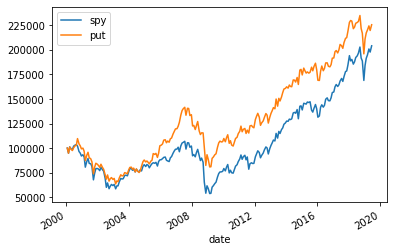

In [46]:
simulate_and_compare(
    build_goal(spx_alloc=0.995, otm_range=(0.2, 0.5), maturity_range=(60, 220)),
    100000
)

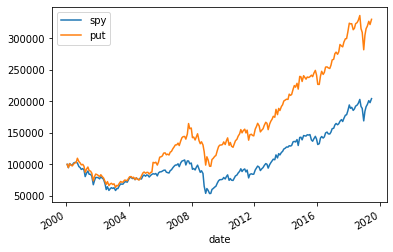

In [47]:
simulate_and_compare(
    build_goal(spx_alloc=0.995, otm_range=(0.2, 0.6), maturity_range=(60, 220)),
    100000
)

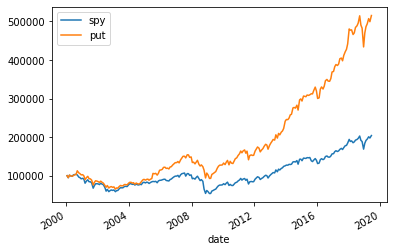

In [48]:
simulate_and_compare(
    build_goal(spx_alloc=0.995, otm_range=(0.2, 0.9), maturity_range=(60, 220)),
    100000
)

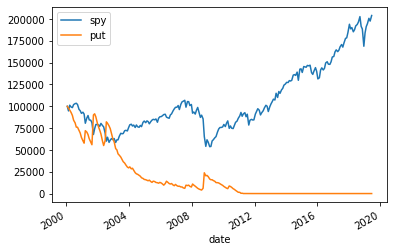

In [49]:
simulate_and_compare(
    build_goal(spx_alloc=0.9, otm_range=(0.2, 0.3), maturity_range=(60, 220)),
    100000
)

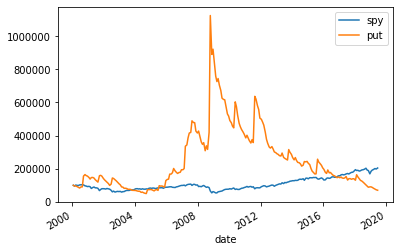

In [50]:
simulate_and_compare(
    build_goal(spx_alloc=0.9, otm_range=(0.2, 0.5), maturity_range=(60, 220)),
    100000
)

## Thoughts


**2nd thought:**

Ah! Maybe it's because...I sell the darn options at the offer price! For the OTM ones, I guess the spread is _very_ high, as they are infrequently traded. Will need to think more about this. Maybe we need a better way to pick the best option


**1st thought:**

Okay, SPY seems to outperform when the OTM range is close to the current price. When it's far out of the money though, the put options seem to outperform.

This is a bit weird though. When I look at the far out of the money options, it seems to do _really_ well. Perhaps...too well. It makes me think that perhaps the data for these options are not representative. Or I have a bug :P

# Iteration

Okay, let's try a few more things. 

Let's both buy and sell at the average between the bid and the offer

Let's also see if we can involve Q ratios

## Q Ratio

In [84]:
Q_RARTIO_FILE_PATH = 'tobins_q.csv'
Q_RATIO_DATE_COL = 'date'
Q_RATIO_VALUE_COL = 'value'
def load_q_ratios():
  q_ratios = pd.read_csv(Q_RARTIO_FILE_PATH)
  q_ratios[Q_RATIO_DATE_COL] = pd.to_datetime(q_ratios[Q_RATIO_DATE_COL])
  q_ratios = q_ratios.set_index(Q_RATIO_DATE_COL, drop=False)
  
  return q_ratios


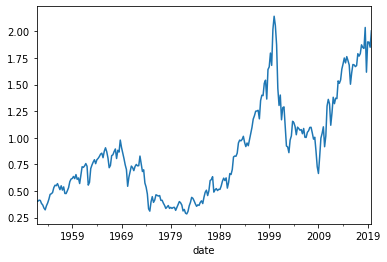

In [85]:
Q_RATIOS = load_q_ratios()
Q_RATIOS[Q_RATIO_VALUE_COL].plot()
plt.show()

In [94]:
def get_q_ratio_for_date(date):
    q_ratios_before_date = Q_RATIOS[Q_RATIOS[Q_RATIO_DATE_COL] < date]
    latest_q_ratio = q_ratios_before_date.last('3D').iloc[0]

    return latest_q_ratio[Q_RATIO_VALUE_COL]

In [95]:
get_q_ratio_for_date(datetime(2000, 1, 3))

2.14224612552741

In [128]:
def trade_for_date(date, goal, portfolio):
  cash_available = liquidate(date, portfolio)
#   spx_alloc = goal[GOAL_SPX_ALLOC] if get_q_ratio_for_date(date) > 1.5 else 1
  
  spx_alloc = goal[GOAL_SPX_ALLOC] if get_q_ratio_for_date(date) > 1.5 else 1
  spx_order, cash_remaining_after_spx = buy_spx_order(date, cash_available, spx_alloc)
  option_order, cash_remaining_after_option = buy_option_order(
    date, 
    cash_remaining_after_spx,
    goal[GOAL_OTM_RANGE],
    goal[GOAL_MATURITY_RANGE],
  )
  return build_portfolio(
    spx_order=spx_order, option_order=option_order, cash=cash_remaining_after_option
  )

def liquidate_option_order(date, option_order):
  options_for_this_date = OPTION_PRICES[
      OPTION_PRICES[OPTION_PRICES_DATE_COL] == date
  ]
  options_with_expiration = options_for_this_date[
    OPTION_PRICES[OPTION_PRICES_EXPIRATION_COL] == 
    option_order[PORTFOLIO_EXPIRATION]
  ]
  options_with_strike = options_with_expiration[
    OPTION_PRICES[OPTION_PRICES_STRIKE_COL] == 
    option_order[PORTFOLIO_STRIKE]
  ]
  found_series = options_with_strike.iloc[0]
  if found_series.empty:
    raise SystemExit("Uh oh. I need to be able to find the option to sell it")
  
  price = found_series[OPTION_PRICES_OFFER_COL] * 0.8
  
  return option_order[PORTFOLIO_QUANTITY] * price

def find_best_option_rows(
  date, 
  otm_range, 
  maturity_range):
  options_on_this_date = OPTION_PRICES[OPTION_PRICES[OPTION_PRICES_DATE_COL] == date]
  options_within_expiration_range = options_on_this_date[
    options_on_this_date[OPTION_PRICES_MATURITY_COL]
      .between(maturity_range[0], maturity_range[1])
  ]
  options_within_otm_range = options_for_otm_range(
    date,
    options_within_expiration_range,
    otm_range
  )
  options_sorted_by_lowest_price_at_highest_strike = options_within_otm_range.sort_values(
    by=[OPTION_PRICES_OFFER_COL, OPTION_PRICES_STRIKE_COL], 
    ascending=[True, False]
  )
  
  return options_sorted_by_lowest_price_at_highest_strike

def buy_option_order(
  date, 
  cash_available, 
  otm_range, 
  maturity_range):
  best_option_rows = find_best_option_rows(
    date, otm_range, maturity_range
  )
  if best_option_rows.empty:
    raise SystemExit("wasn't able to find an option for {}".format(date))
  best_option_row = best_option_rows.iloc[0]
  strike = best_option_row[OPTION_PRICES_STRIKE_COL]
  expiration = best_option_row[OPTION_PRICES_EXPIRATION_COL]
  price = best_option_row[OPTION_PRICES_OFFER_COL] * 0.8
  quantity = cash_available // price
  
  option_order = build_option_order(quantity=quantity, strike=strike, expiration_date=expiration)
  cash_remaining = cash_available - (quantity * price)
  
  return (option_order, cash_remaining)

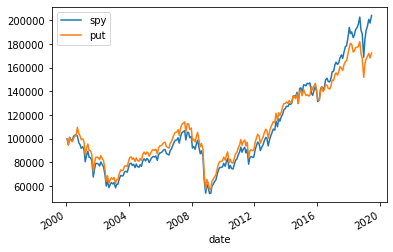

In [129]:
simulate_and_compare(
    build_goal(spx_alloc=0.995, otm_range=(0.2, 0.5), maturity_range=(60, 220)),
    100000
)